In [1]:
from system import TradingEnv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

/home/aaruran/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
e = TradingEnv()
STATE_DIM = len(e.reset())
print(f'STATE_DIM = {STATE_DIM}')
EMBED_DIM = 50 # from the dimensionality-reduced fastText model
ACTION_DIM = 3
EPISODES = 2000  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
# GAMMA = 0.99  # Q-learning discount factor
LR = 1  # NN optimizer learning rate
HIDDEN_LAYER = 128  # NN hidden layer size
BATCH_SIZE = 16  # Q-learning batch size
TARGET_UPDATE = 100  # frequency of target update
BUFFER_SIZE = 100  # capacity of the replay buffer 

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor  = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor  = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
del e

STATE_DIM = 48


In [13]:
if use_cuda:
    print('GPU found and in use')
else:
    print('No GPU will be used')

No GPU will be used


# Simple QNetwork 
Corresponds to a fully connected network with two hidden layers

In [14]:
class QNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)
                
    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x      
    
    def sample_from_softmax_policy(self, batch_state):
        batch_q_values = self.forward(batch_state)
        batch_pi = F.softmax(batch_q_values, dim=1)
        batch_size = batch_pi.shape[0]
        batch_actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            # Subtract 1, so batch_actions is in {-1, 0, 1}
            batch_actions[i, 0] = dist.sample().view(1,1) - 1
        if use_cuda:
            batch_actions = batch_actions.to(batch_state.get_device())
        return batch_actions.long()

# Generic Training Agent

In [189]:
class BaseAgent:
    def __init__(self, gamma=0.99):
        assert 0 < gamma < 1, f"Invalid gamma: {gamma}" 
        self.gamma = gamma
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.history = pd.DataFrame()
        self.rewards_history = []
        self.steps_done = 0
        with open('sp500.txt', 'r') as src:
            self.filtered_tickers = src.read().split(',')
        
    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
            Must return environment.close()
        """
        raise NotImplementedError()
    
    def plot_cumulative_discounted_rewards(self):
        rewards = np.array(self.rewards_history)
        discount_array = np.power(self.gamma, np.arange(rewards.shape[0]))
        plt.plot((discount_array[:, None] * rewards).sum(axis=1))
        plt.grid()
        plt.ylabel('Cumulative Discounted Rewards')
        plt.xlabel('Episode')

    def convert_action(self, action):
        """
            Takes action of shape 1 x 3, and converts into an integer in {-1, 0, 1}.
            This integer is the position short/hold/long respectively.
        """
        position = action - 1
#         assert position in [-1,0,1]
        return position.item()
    
    def train(self, env_mode='dev', num_tickers=20, num_episodes = 5):
        """
            Trains the agent for num_tickers episodes, looping over the approved
            list of tickers. This is a convenience function.
        """
        if num_tickers == np.Inf:
            num_tickers = len(self.filtered_tickers)
        self.history = pd.DataFrame()
        for e in tqdm(range(num_episodes)):
            for i in range(num_tickers):
                ticker = self.filtered_tickers[ i % len(self.filtered_tickers)]
                env = TradingEnv(ticker=ticker, mode=env_mode)
                history = self.run_episode(env)
                history['ticker'] = ticker
                history['episode'] = e + 1
                self.history = pd.concat((self.history, history))

        self.history = self.history.set_index(['date', 'ticker', 'episode'])
        self.history = self.history.unstack(level=1).swaplevel(0,1,1)
        self.history = self.history.swaplevel(0,1,0).sort_index(1,0)

        for i in range(num_tickers):
            ticker = self.filtered_tickers[ i % len(self.filtered_tickers)]
            
            rl_data = pd.DataFrame(self.history[ticker, 'rewards'])[ticker]
            rl_data = rl_data.reset_index(['date', 'episode'])
            rl_data['discount_factor'] = np.power(self.gamma, rl_data.episode-1)
            rl_data['discounted_future_reward'] = rl_data['discount_factor'] * rl_data['rewards']
            rl_data = rl_data[['episode', 'discounted_future_reward']]
            rl_data.groupby('episode').sum().plot(title=f'Cumulative Disc. Reward for {ticker}',
                                                  legend=False, y='discounted_future_reward')
            plt.grid()
            
            roi_data = pd.DataFrame(self.history[ticker, 'returns'])[ticker]
            roi_data = roi_data.reset_index(level='episode')
            roi_data = roi_data.reset_index(level='date')
            roi_data = roi_data.pivot(index='date',columns='episode')['returns']
            roi_data.plot(title=f'Returns on {ticker}')
            

        
class DQN(BaseAgent):
    def __init__(self):
        super().__init__()
        self.model = QNetwork()
        self.target = QNetwork()
        self.optimizer = optim.Adam(self.model.parameters(), LR)

    def select_epsilon_greedy_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        greedy_action = None
        with torch.no_grad():
            greedy_action = self.model(s0).data.argmax(dim=1).view(1,1)
        
        random_action = LongTensor([[random.randrange(ACTION_DIM)]])
        assert greedy_action.shape == random_action.shape, f"Incorrect sampling techinque {greedy_action.shape, random_action.shape}"
        if sample > eps_threshold:
            return greedy_action
        else:
            return random_action
    
    def run_episode(self, environment):
        self.memory = ReplayMemory(self.memory.capacity)
        state = environment.reset()
        steps = 0
        action = None
        while True:
            state_tensor = FloatTensor([state])
            action = self.select_epsilon_greedy_action(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
            
            self.memory.push(
                (
                    FloatTensor([state]),
                    action,  # action is already a tensor
                    FloatTensor([next_state]),
                    FloatTensor([reward]),
                    FloatTensor([int(done)])
                )
            )

            self.learn()
            if self.steps_done % TARGET_UPDATE == 0:
                self.target.load_state_dict(self.model.state_dict())
        
            state = next_state
            steps += 1
            if done:
                break
        history = environment.close()
        return history

    def max_next_q_values(self, batch_next_state):
        # expected Q values are estimated from actions which gives maximum Q value
        return self.target(batch_next_state).detach().max(1)[0]
    
    def learn(self):
        if len(self.memory) <= BATCH_SIZE:
            return
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = Variable(torch.cat(batch_done))

        # current Q values are estimated by NN for all actions
        current_q_values = self.model(batch_state).gather(1, batch_action).squeeze()
        expected_future_rewards = self.max_next_q_values(batch_next_state)
        
        expected_q_values = batch_reward + (self.gamma * expected_future_rewards) * (1 - batch_done)

        # loss is measured from error between current and newly expected Q values
        loss = F.mse_loss(current_q_values, expected_q_values)

        # backpropagation of loss to QNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


# agent=DQN()
# env = TradingEnv()
# for i in range(10):
#     s = FloatTensor([env.reset()])
#     agent.steps_done=100
#     print(agent.select_epsilon_greedy_action(s))

# agent.run_episode(env)

  0%|          | 0/5 [00:00<?, ?it/s]

action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[0]])
position = -1
action = tensor([[2]])
position = 1
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[0]])
position = -1
action = tensor([[0]])
position = -1
action = tensor([[2]])
position = 1
action = tensor([[0]])
position = -1
action = tensor([[0

 20%|██        | 1/5 [00:01<00:05,  1.27s/it]

action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[0]])
position = -1
action = tensor([[0]

 40%|████      | 2/5 [00:02<00:03,  1.28s/it]

action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
posi

 60%|██████    | 3/5 [00:03<00:02,  1.20s/it]

action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
posit

 80%|████████  | 4/5 [00:04<00:01,  1.15s/it]

position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[2]])
position = 1
action = tensor

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]

action = tensor([[0]])
position = -1
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[0]])
position = -1
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
position = 0
action = tensor([[1]])
po

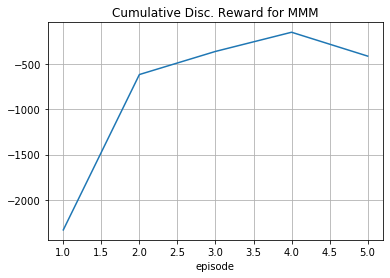

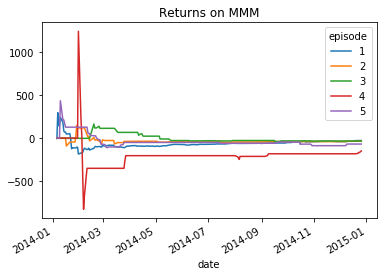

In [190]:
agent=DQN()
agent.train(num_tickers=1, num_episodes=5)

In [180]:
e = TradingEnv()
s0 = FloatTensor([e.reset()])
with torch.no_grad():
#     greedy_action = agent.model(s0).data.max(1)[1].view(1, 1)
    greedy_action = agent.model(s0).data.argmax(dim=1).view(1,1)
    print(greedy_action)

tensor([[0]])


In [172]:
print(agent.convert_action(FloatTensor([[1,0,0]])))
print(agent.convert_action(FloatTensor([[0,1,0]])))
print(agent.convert_action(FloatTensor([[0,0,1]])))

-1
0
1


In [183]:
agent.history['MMM', 'actions'].max()

-1

In [123]:
with torch.no_grad():
    a = agent.target(s0).data
    posn = agent.convert_action(a)
    posn2 = a.argmax()
    print(a)
    print((posn, posn2))
#     print(agent.target(s0).data.max(1)[1].view(1, 1))

tensor([[5410.3145, 5000.5098, 5269.0034]])
(-1, tensor(0))


In [91]:
for i, t in enumerate(agent.memory.memory):
    if i > 10:
        break
    action = t[1]
    print(f'action = {action}, ', end= ' ')
    position = action.item() - 1
#     position = agent.convert_action(action)
    print(f'position = {position}')

action = tensor([[2]]),  position = 1
action = tensor([[0]]),  position = -1
action = tensor([[1]]),  position = 0
action = tensor([[2]]),  position = 1
action = tensor([[0]]),  position = -1
action = tensor([[2]]),  position = 1
action = tensor([[2]]),  position = 1
action = tensor([[2]]),  position = 1
action = tensor([[0]]),  position = -1
action = tensor([[1]]),  position = 0
action = tensor([[0]]),  position = -1


In [ ]:
STATE_DIM

In [ ]:
dqn_agent = DQN()
for _ in range(10):
    random_state = FloatTensor([np.random.randn(98)])
    q_values = dqn_agent.target(random_state).detach()
    print(f'q_values = {q_values},')
    print(f'max_next_q_values = {dqn_agent.max_next_q_values(random_state)}')
    with torch.no_grad():
        optimal_action = q_values.data.max(1)[1].view(1, 1)
        print(f'optimal_action = {optimal_action}')

In [ ]:
agent.history['MMM', 'rewards'].unstack(level=0)[1].apply(lambda x : x.item()).plot()

In [ ]:
plt.plot(agent.rewards_history[-1])

In [ ]:
plt.plot(agent.rewards_history[0])

In [ ]:
agent.plot_cumulative_discounted_rewards()

In [ ]:
# %load_ext line_profiler

In [ ]:
# e = TradingEnv()

In [ ]:
# %lprun -f agent.learn [agent.run_episode(e) for _ in range(10)]

In [ ]:
# _ = e.reset()
# %lprun -f e.step e.step(1)

In [ ]:
plt.plot(e.prices)

# Policy Network

In [ ]:
class PolicyNetwork(nn.Module):
    # for Policy-Gradient methods, e.g. actor-only and actor-critic methods
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, 2) # 2, for the action

    def forward(self, x, d=1, get_log=False):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        if not get_log:
            x = F.softmax(self.l3(x), dim=d)
        else:
            x = F.log_softmax(self.l3(x), dim=d)
        return x
    
    def sample_from_softmax_policy(self, batch_state):
        batch_pi = self.forward(batch_state)
        batch_size = batch_pi.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            actions[i, 0] = dist.sample().view(1,1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

# p = PolicyNetwork()
# state = env.reset()
# state_tensor = FloatTensor([state]).cuda()
# p.cuda()
# p.forward(state_tensor, d=1), p.forward(state_tensor, d=-1)
# p.sample_from_softmax_policy(torch.cat(5*[state_tensor])).shape

# LongOnly Agent

In [82]:
class LongOnlyAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        position = 1
        while True:
#             if steps % 50 == 0:
#                 print(f'steps = {steps}')
            _, r, done, __ = environment.step(position)

            self.steps_done += 1
            steps += 1
            if done:
                break
        self.rewards_history.append(environment.rewards_list)
        return environment.close()

# long_agent = LongOnlyAgent()
# e = TradingEnv()
# long_agent.run_episode(e)
# # long_agent.rewards_history
# long_agent.run_episode(e)

In [83]:
long_agent = LongOnlyAgent()

100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


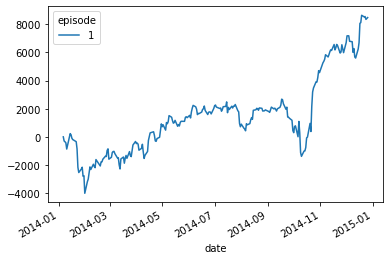

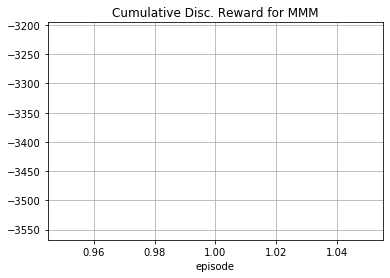

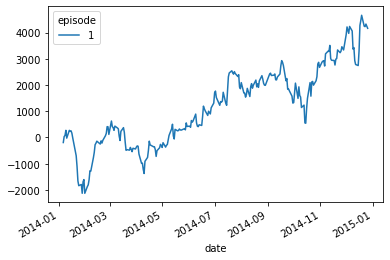

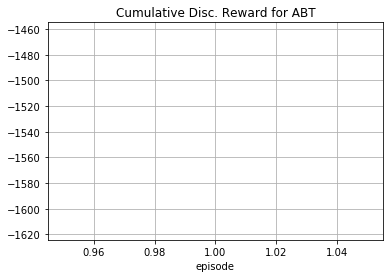

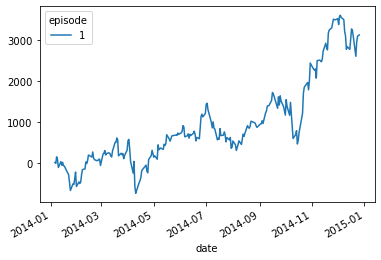

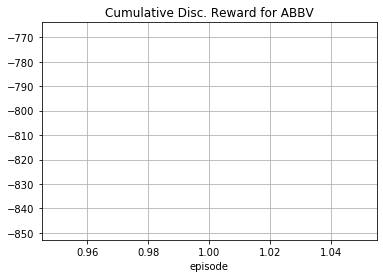

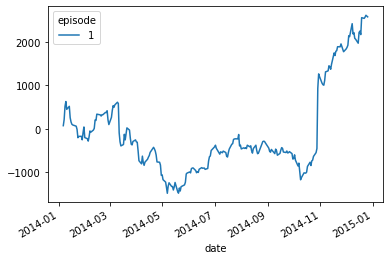

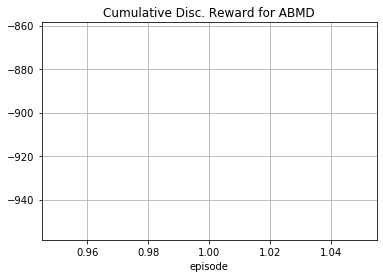

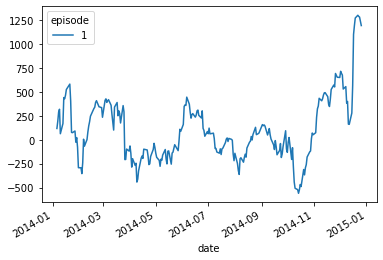

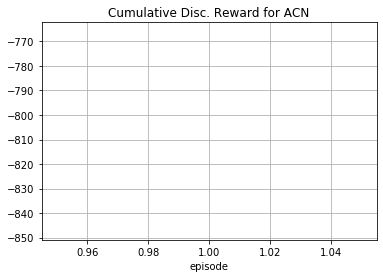

In [86]:
long_agent.train(num_tickers=5, num_episodes=1)

In [ ]:
agent.plot_cumulative_discounted_rewards()

# A2C

In [ ]:
class A2C(BaseAgent):
    def __init__(self):
        super().__init__()
        
        


 # Model-based (using Reddit Comments)

In [ ]:
class ModelBasedAgent(BaseAgent):
    def __init__(self):
        super().__init__()